# HAI-21.03 Dataset Model Evaluation

This notebook focuses on evaluating the trained LSTM autoencoder model on test data.

In [4]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Global Variables Setup

In [5]:
# Set paths
OUTPUT_DIR = '../../hai-security-dataset/processed'
MODEL_DIR = '../../models/simplified_lstm'

# Set anomaly detection parameters
ANOMALY_SCORE_THRESHOLD = 0.65  # Threshold for anomaly scores
MIN_ANOMALY_LENGTH = 30        # Minimum length of anomalies to keep
GAP_THRESHOLD = 3              # Maximum gap between anomalies to merge

## 2. Load Model and Parameters

In [6]:
# Define MSE function directly to avoid import issues
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define custom objects dictionary
custom_objects = {'mse': mse}

# Load model with custom objects
model = load_model(os.path.join(MODEL_DIR, 'simplified_lstm.h5'), custom_objects=custom_objects)
print("Loaded model")

# Load model parameters
with open(os.path.join(MODEL_DIR, 'model_params.pkl'), 'rb') as f:
    model_params = pickle.load(f)
    
SEQ_LENGTH = model_params['seq_length']
STRIDE = model_params['stride']
n_components = model_params['n_components']
threshold = model_params['threshold']
top_features = model_params['top_features']

print(f"Loaded model parameters: SEQ_LENGTH={SEQ_LENGTH}, STRIDE={STRIDE}, threshold={threshold:.6f}")

# Load scaler and PCA
with open(os.path.join(OUTPUT_DIR, 'scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)
    
with open(os.path.join(OUTPUT_DIR, 'pca.pkl'), 'rb') as f:
    pca = pickle.load(f)
    
print("Loaded scaler and PCA")

I0000 00:00:1741956161.968956  172140 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741956162.008303  172140 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741956162.008573  172140 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741956162.010098  172140 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Loaded model
Loaded model parameters: SEQ_LENGTH=128, STRIDE=10, threshold=31.110460
Loaded scaler and PCA


## 3. Load Test Data

In [7]:
# Load test data
test_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('test') and f.endswith('_processed.csv')]
test_data = {}

for file in test_files:
    file_path = os.path.join(OUTPUT_DIR, file)
    file_name = file.split('_')[0]  # Extract test file name (e.g., 'test1')
    df = pd.read_csv(file_path)
    test_data[file_name] = df
    print(f"Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded test1: 43201 rows, 84 columns
Loaded test2: 118801 rows, 84 columns
Loaded test5: 92401 rows, 84 columns
Loaded test3: 108001 rows, 84 columns
Loaded test4: 39601 rows, 84 columns


## 4. Define Anomaly Detection Functions

In [8]:
def create_sequences(data, seq_length=128, stride=10):
    """
    Create sequences for time series models.
    
    Args:
        data (np.array): Input data
        seq_length (int): Sequence length
        stride (int): Stride for sliding window
        
    Returns:
        np.array: Sequences
    """
    sequences = []
    for i in range(0, len(data) - seq_length + 1, stride):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    
    return np.array(sequences)

In [9]:
def post_process_anomalies(anomaly_labels, min_anomaly_length=30, gap_threshold=3):
    """
    Apply post-processing to reduce false positives and false negatives.
    
    Args:
        anomaly_labels (np.array): Binary anomaly labels
        min_anomaly_length (int): Minimum length of anomalies to keep
        gap_threshold (int): Maximum gap between anomalies to merge
        
    Returns:
        np.array: Processed binary anomaly labels
    """
    # Make a copy to avoid modifying the original
    processed_labels = anomaly_labels.copy()
    
    # Remove short anomalies (likely false positives)
    i = 0
    while i < len(processed_labels):
        if processed_labels[i] == 1:
            # Find the end of this anomaly
            j = i
            while j < len(processed_labels) and processed_labels[j] == 1:
                j += 1
            
            # If anomaly is too short, remove it
            if j - i < min_anomaly_length:
                processed_labels[i:j] = 0
            
            i = j
        else:
            i += 1
    
    # Merge nearby anomalies
    i = 0
    while i < len(processed_labels):
        if processed_labels[i] == 1:
            # Find the end of this anomaly
            j = i
            while j < len(processed_labels) and processed_labels[j] == 1:
                j += 1
            
            # Look for another anomaly nearby
            if j < len(processed_labels) - gap_threshold:
                next_start = j
                while next_start < j + gap_threshold and next_start < len(processed_labels) and processed_labels[next_start] == 0:
                    next_start += 1
                
                if next_start < j + gap_threshold and next_start < len(processed_labels) and processed_labels[next_start] == 1:
                    processed_labels[j:next_start] = 1
            
            i = j
        else:
            i += 1
    
    return processed_labels

In [10]:
def detect_anomalies(model, X_test_seq, seq_length, stride, data_length, threshold, anomaly_score_threshold=0.65):
    """
    Detect anomalies using the trained model.
    
    Args:
        model (Model): Trained model
        X_test_seq (np.array): Test sequences
        seq_length (int): Sequence length
        stride (int): Stride used for sequences
        data_length (int): Original data length
        threshold (float): Anomaly detection threshold
        anomaly_score_threshold (float): Anomaly score threshold
        
    Returns:
        tuple: (anomaly_scores, anomaly_labels)
    """
    # Get predictions from model
    X_test_pred = model.predict(X_test_seq)
    mse = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))
    
    # Initialize anomaly scores array
    anomaly_scores = np.zeros(data_length)
    count = np.zeros(data_length)
    
    # For each sequence, if it's anomalous, increment the score for all points in the sequence
    for i, error in enumerate(mse):
        idx = i * stride
        if idx + seq_length <= data_length:
            if error > threshold:
                anomaly_scores[idx:idx+seq_length] += 1
            count[idx:idx+seq_length] += 1
    
    # Normalize scores by count
    anomaly_scores = np.divide(anomaly_scores, count, out=np.zeros_like(anomaly_scores), where=count!=0)
    
    # Apply threshold to get binary labels
    anomaly_labels = (anomaly_scores > anomaly_score_threshold).astype(int)
    
    # Apply post-processing
    anomaly_labels = post_process_anomalies(anomaly_labels, min_anomaly_length=MIN_ANOMALY_LENGTH, gap_threshold=GAP_THRESHOLD)
    
    return anomaly_scores, anomaly_labels

In [11]:
def evaluate_model(y_true, y_pred):
    """
    Evaluate model performance.
    
    Args:
        y_true (np.array): Ground truth labels
        y_pred (np.array): Predicted labels
        
    Returns:
        dict: Evaluation metrics
    """
    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Store results
    results = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'confusion_matrix': cm,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
    }
    
    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    
    return results

## 5. Evaluate on Test Files

In [12]:
def evaluate_test_file(test_name, test_df):
    """
    Evaluate model on a single test file.
    
    Args:
        test_name (str): Name of the test file
        test_df (pd.DataFrame): Test dataframe
        
    Returns:
        dict: Evaluation results
    """
    print(f"\nEvaluating test file: {test_name}")
    
    # Extract features
    X_test_features = test_df[top_features].values
    
    # Extract labels
    y_test = test_df['attack'].values if 'attack' in test_df.columns else None
    
    # Scale data
    X_test_scaled = scaler.transform(X_test_features)
    
    # Apply PCA
    X_test_pca = pca.transform(X_test_scaled)
    
    # Create sequences
    X_test_seq = create_sequences(X_test_pca, SEQ_LENGTH, STRIDE)
    
    # Detect anomalies
    anomaly_scores, anomaly_labels = detect_anomalies(
        model, X_test_seq, SEQ_LENGTH, STRIDE, len(y_test), threshold, ANOMALY_SCORE_THRESHOLD
    )
    
    # Evaluate model
    eval_results = evaluate_model(y_test, anomaly_labels)
    
    # Visualize results
    plt.figure(figsize=(20, 10))
    
    # Plot ground truth
    plt.subplot(3, 1, 1)
    plt.plot(y_test, 'b-', label='Ground Truth')
    plt.title(f'Ground Truth - {test_name}')
    plt.ylabel('Anomaly')
    plt.yticks([0, 1])
    plt.grid(True)
    plt.legend()
    
    # Plot anomaly scores
    plt.subplot(3, 1, 2)
    plt.plot(anomaly_scores, 'r-', label='Anomaly Scores')
    plt.axhline(y=ANOMALY_SCORE_THRESHOLD, color='g', linestyle='--', label=f'Score Threshold ({ANOMALY_SCORE_THRESHOLD})')
    plt.title(f'Anomaly Scores - {test_name}')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    
    # Plot predictions
    plt.subplot(3, 1, 3)
    plt.plot(anomaly_labels, 'g-', label='Predictions')
    plt.title(f'Predictions - {test_name}')
    plt.xlabel('Time')
    plt.ylabel('Anomaly')
    plt.yticks([0, 1])
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix
    cm = eval_results['confusion_matrix']
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {test_name}')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Normal', 'Anomaly'], rotation=45)
    plt.yticks(tick_marks, ['Normal', 'Anomaly'])
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Return results
    return {
        'Test File': test_name,
        'Precision': eval_results['precision'],
        'Recall': eval_results['recall'],
        'F1 Score': eval_results['f1_score'],
        'Accuracy': eval_results['accuracy'],
        'False Positive Rate': eval_results['false_positive_rate'],
        'False Negative Rate': eval_results['false_negative_rate'],
        'Anomaly Scores': anomaly_scores,
        'Anomaly Labels': anomaly_labels,
        'Ground Truth': y_test
    }


Evaluating test file: test1


2025-03-14 12:42:45.022572: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step    
Precision: 0.7387
Recall: 0.8315
F1 Score: 0.7823
Accuracy: 0.9933
False Positive Rate: 0.0043
False Negative Rate: 0.1685


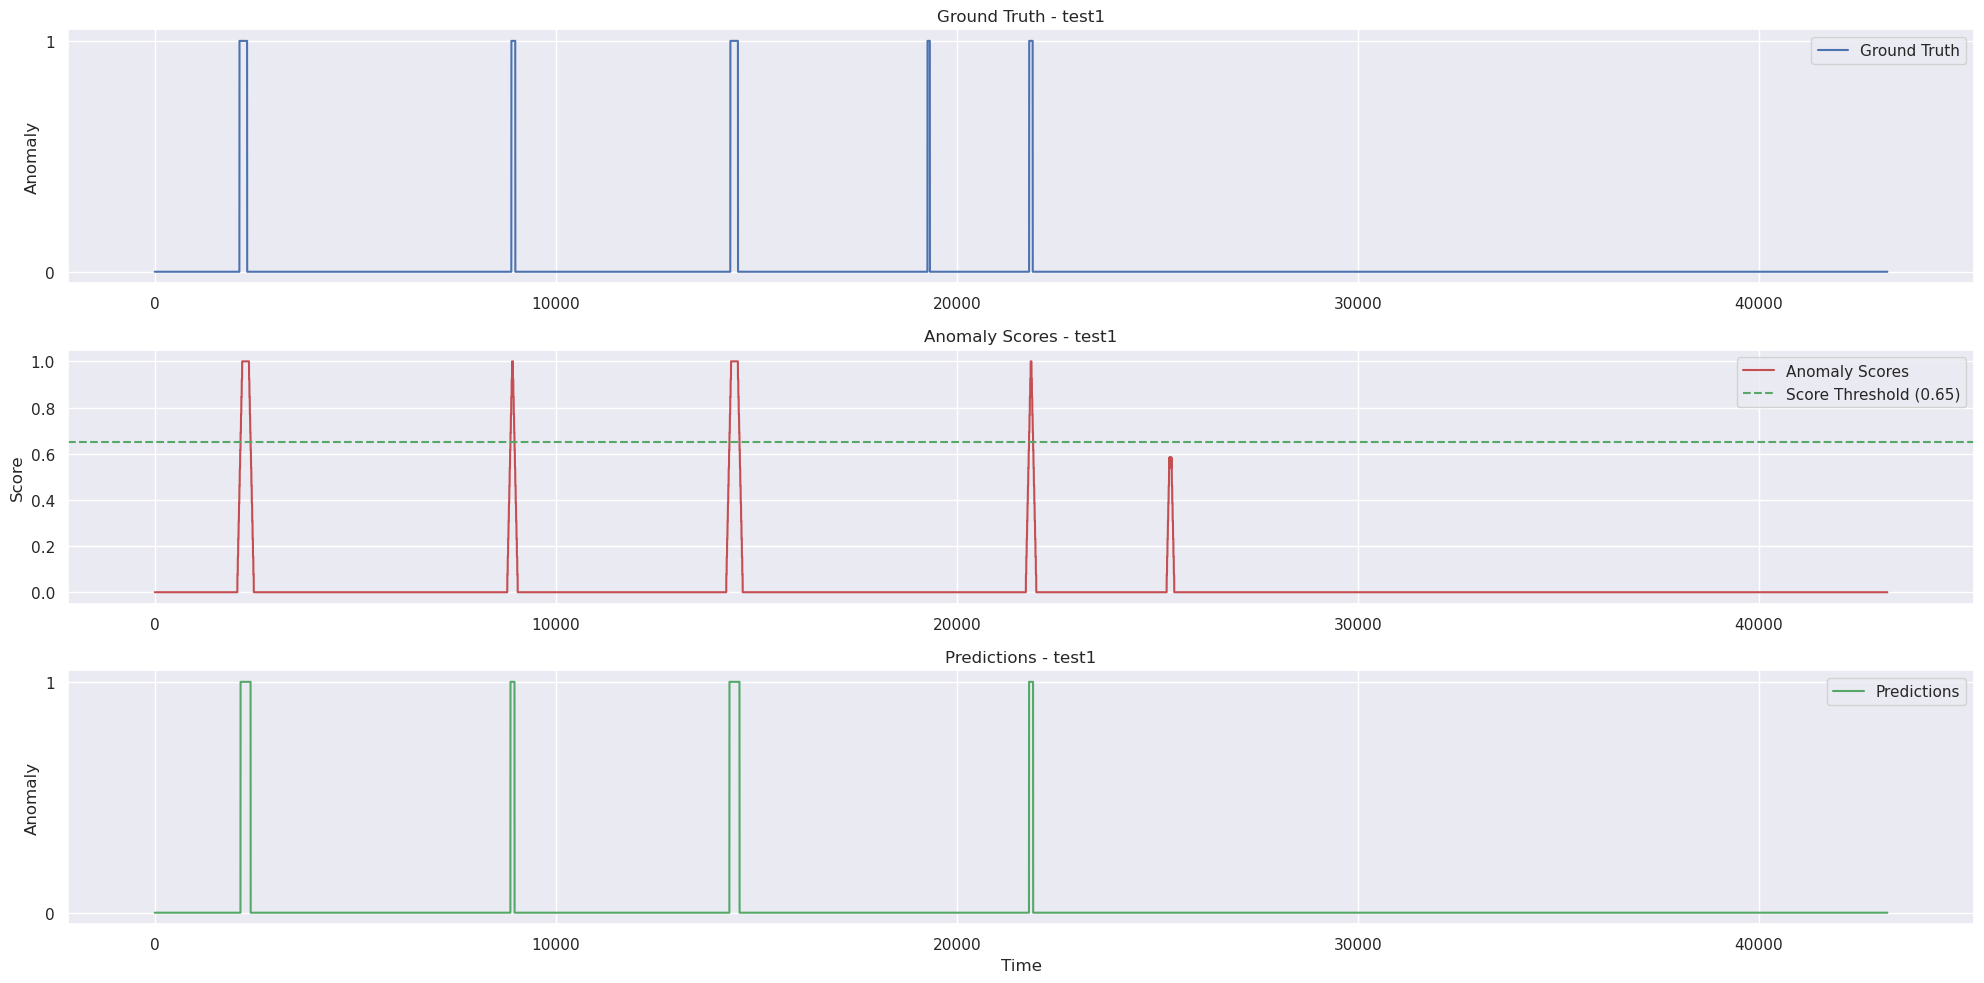

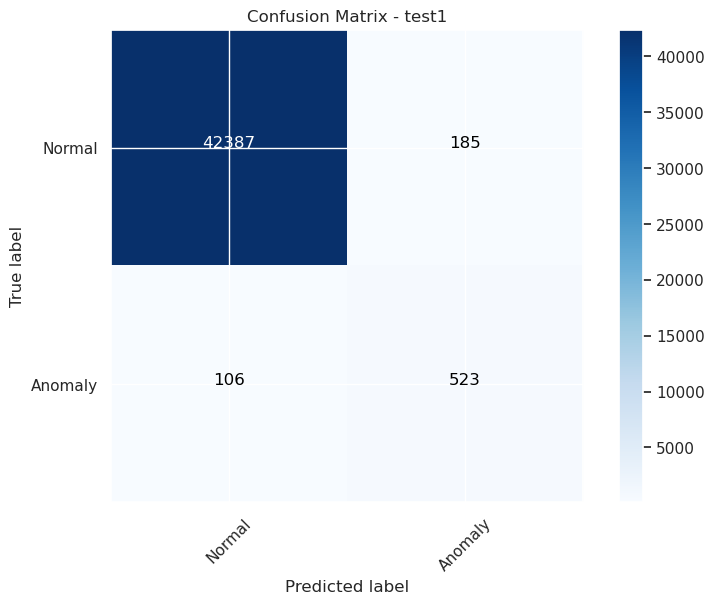


Evaluating test file: test2
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Precision: 0.6141
Recall: 0.3871
F1 Score: 0.4748
Accuracy: 0.9751
False Positive Rate: 0.0073
False Negative Rate: 0.6129


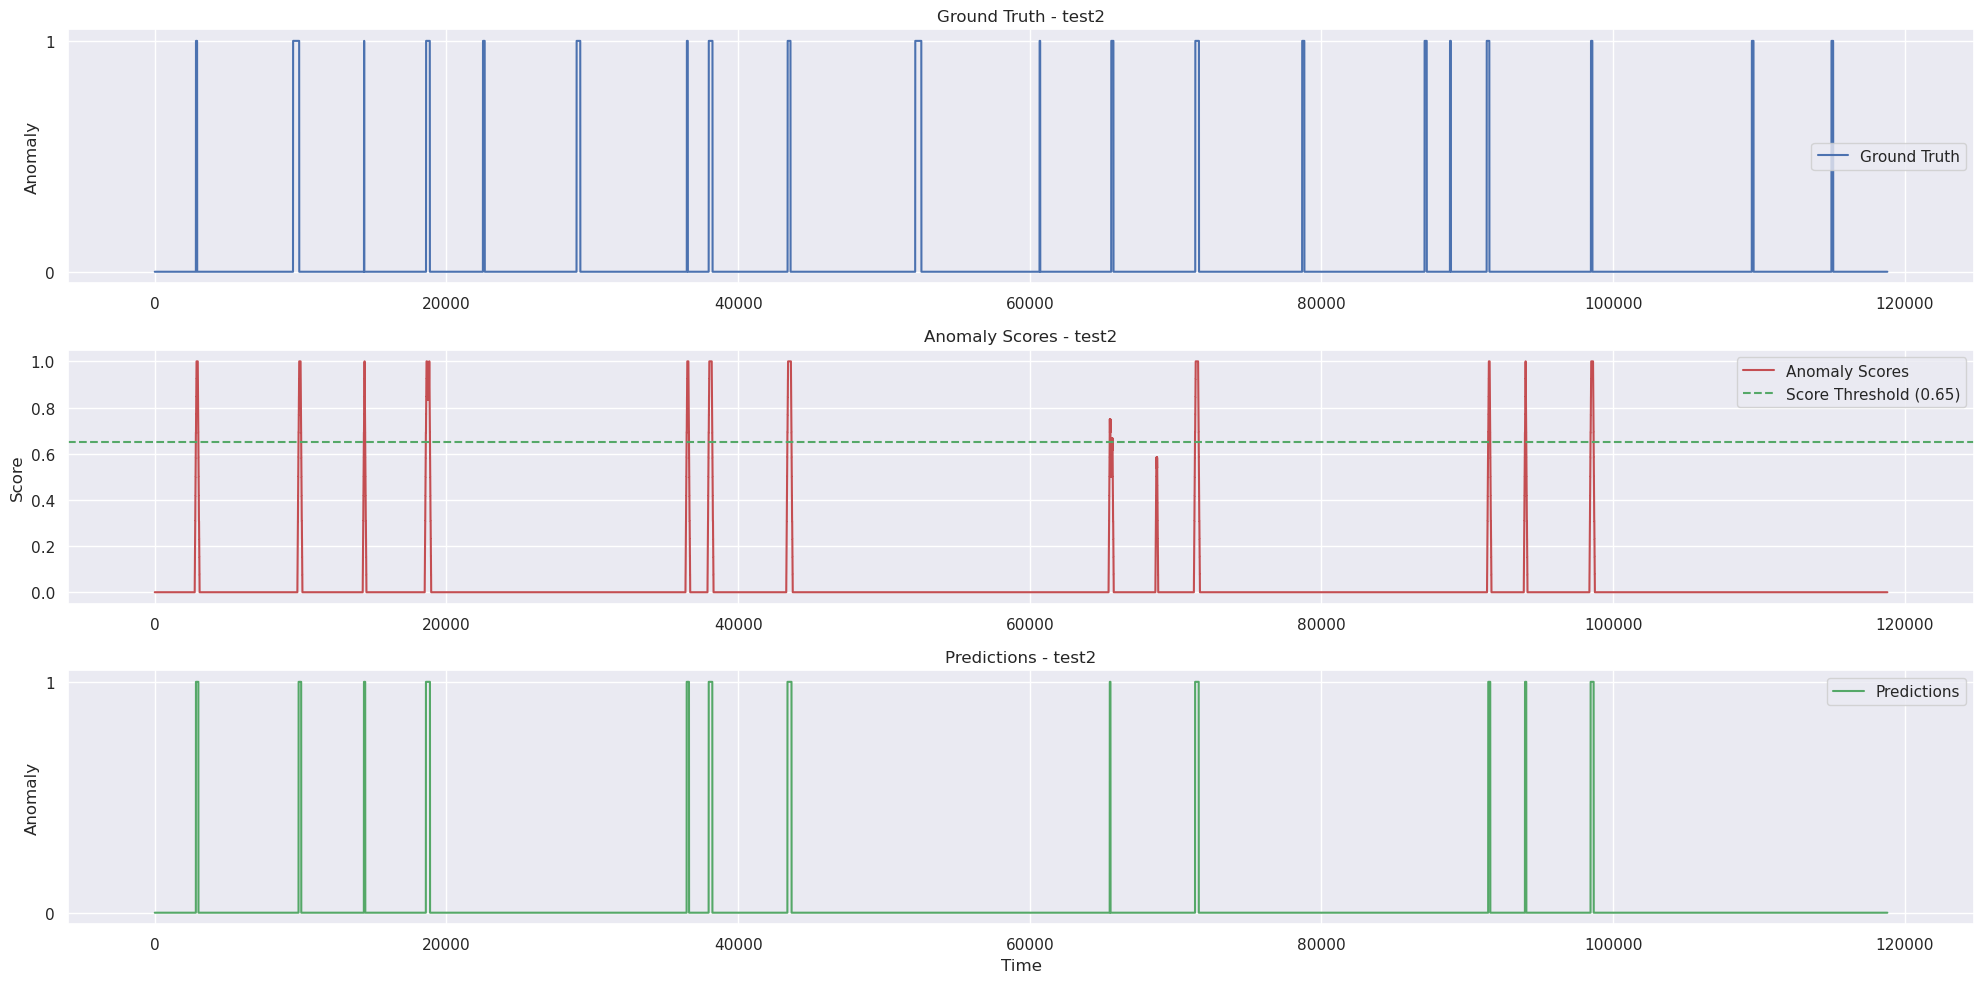

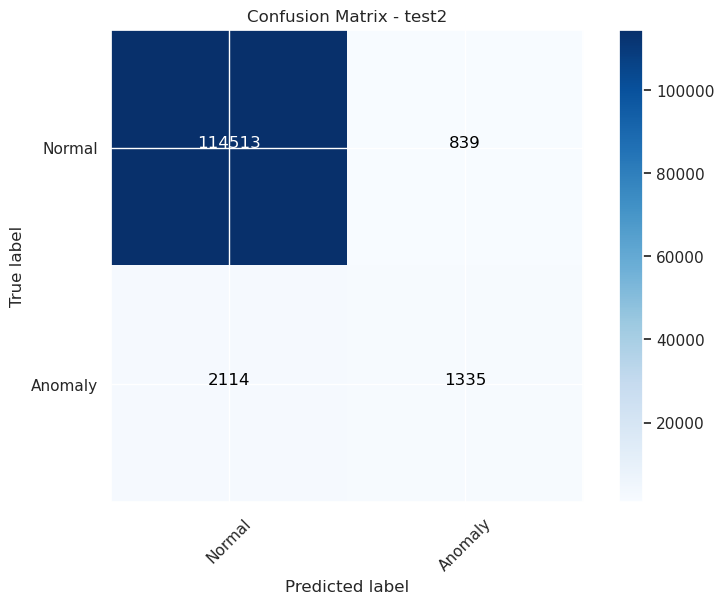


Evaluating test file: test5
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.5790
Recall: 0.7235
F1 Score: 0.6433
Accuracy: 0.9811
False Positive Rate: 0.0127
False Negative Rate: 0.2765


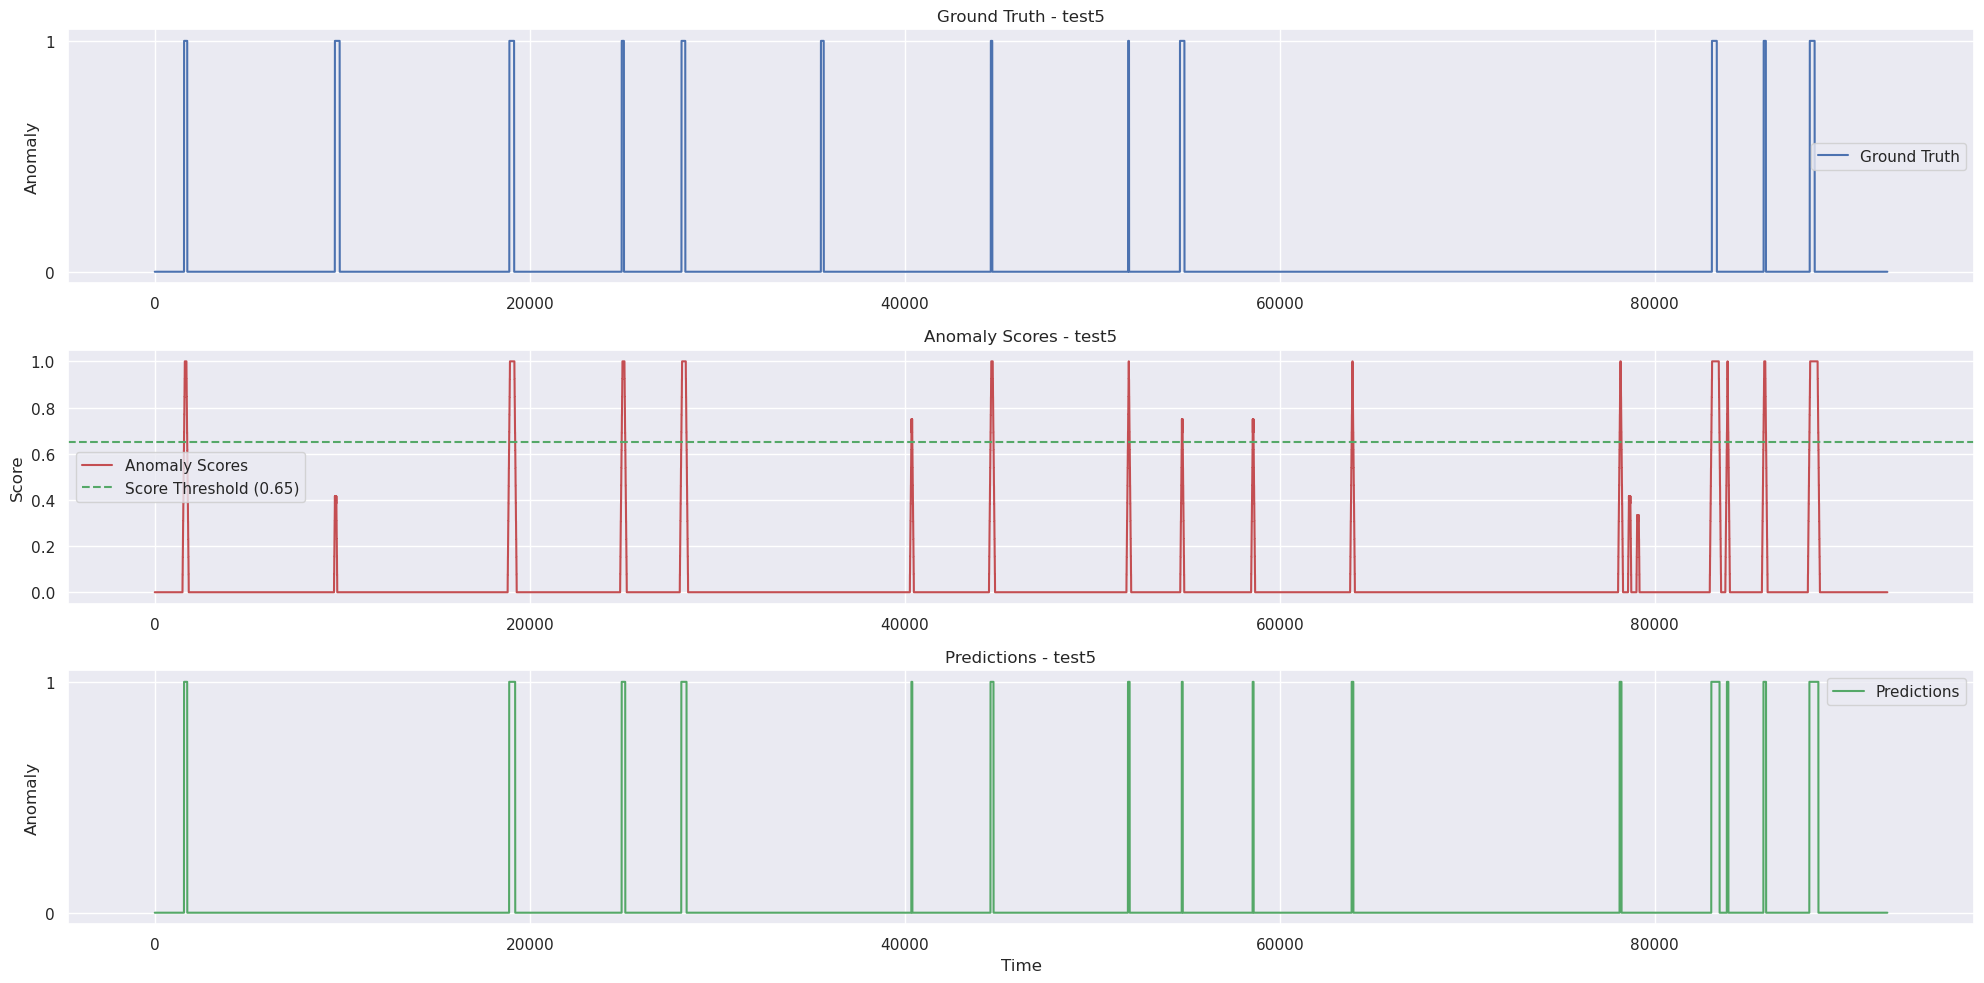

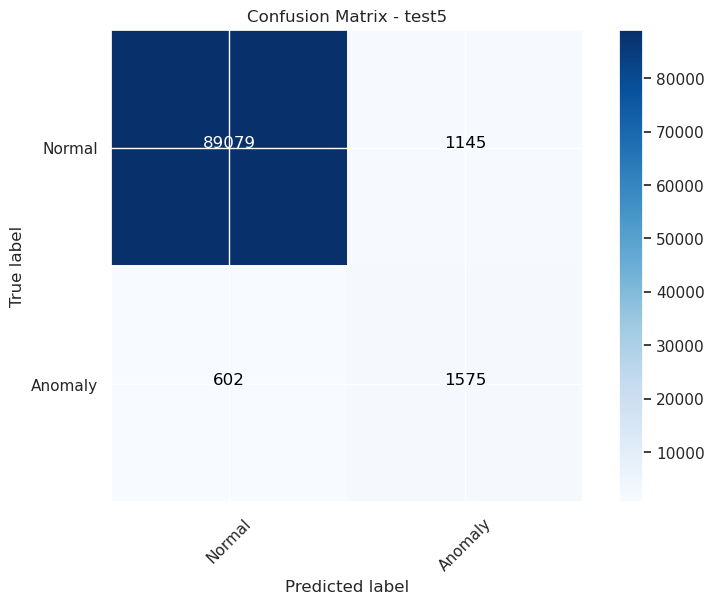


Evaluating test file: test3
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.5870
Recall: 0.6463
F1 Score: 0.6152
Accuracy: 0.9885
False Positive Rate: 0.0066
False Negative Rate: 0.3537


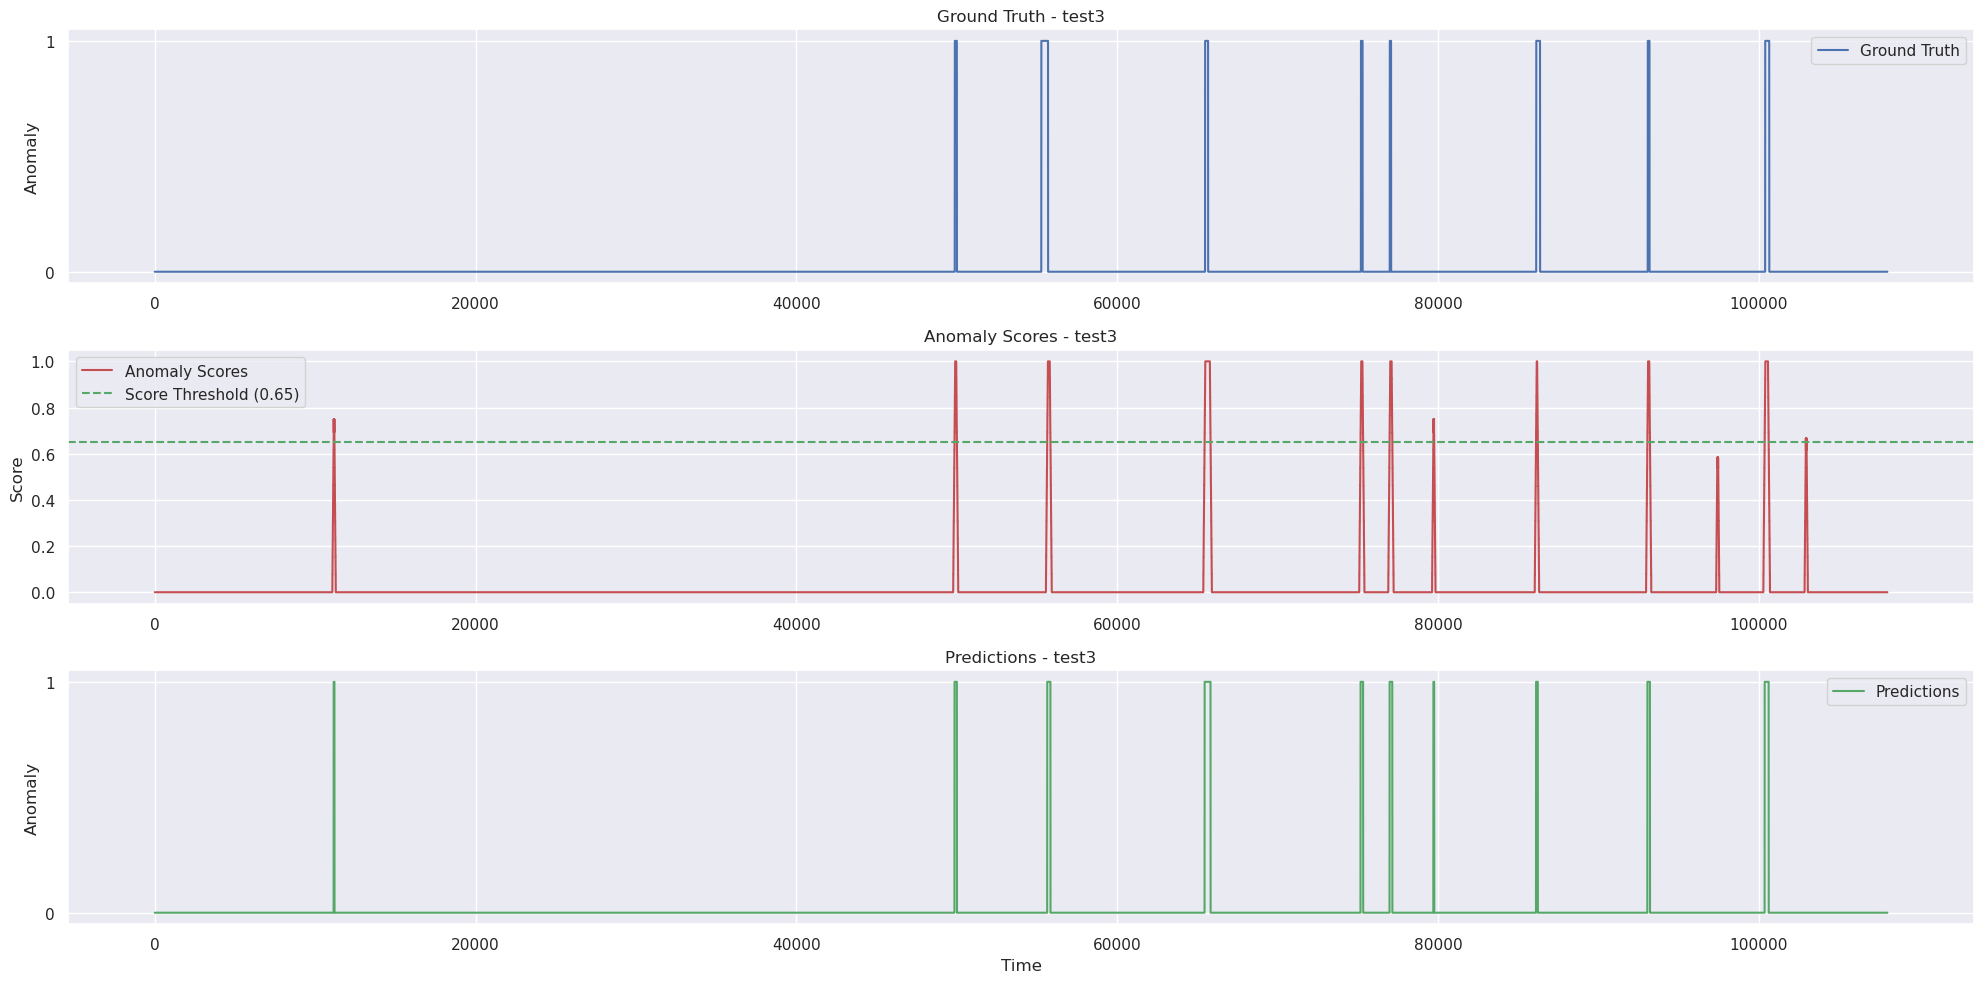

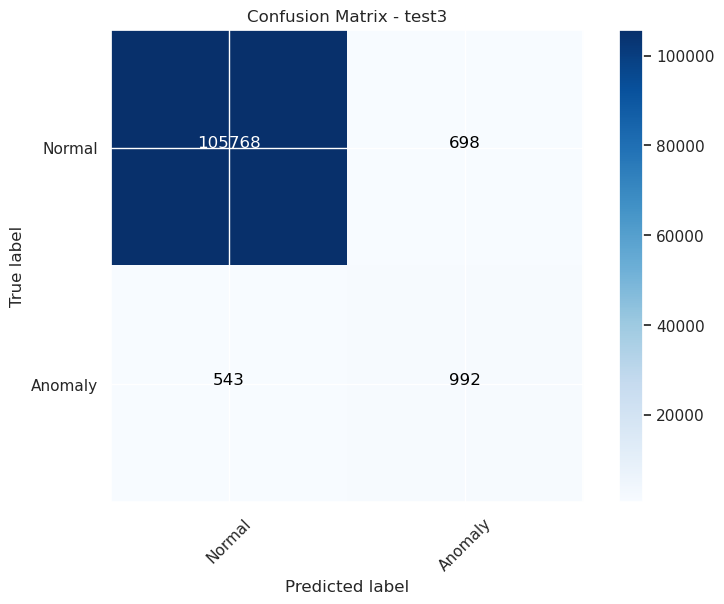


Evaluating test file: test4
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
Precision: 0.7681
Recall: 0.8963
F1 Score: 0.8273
Accuracy: 0.9891
False Positive Rate: 0.0081
False Negative Rate: 0.1037


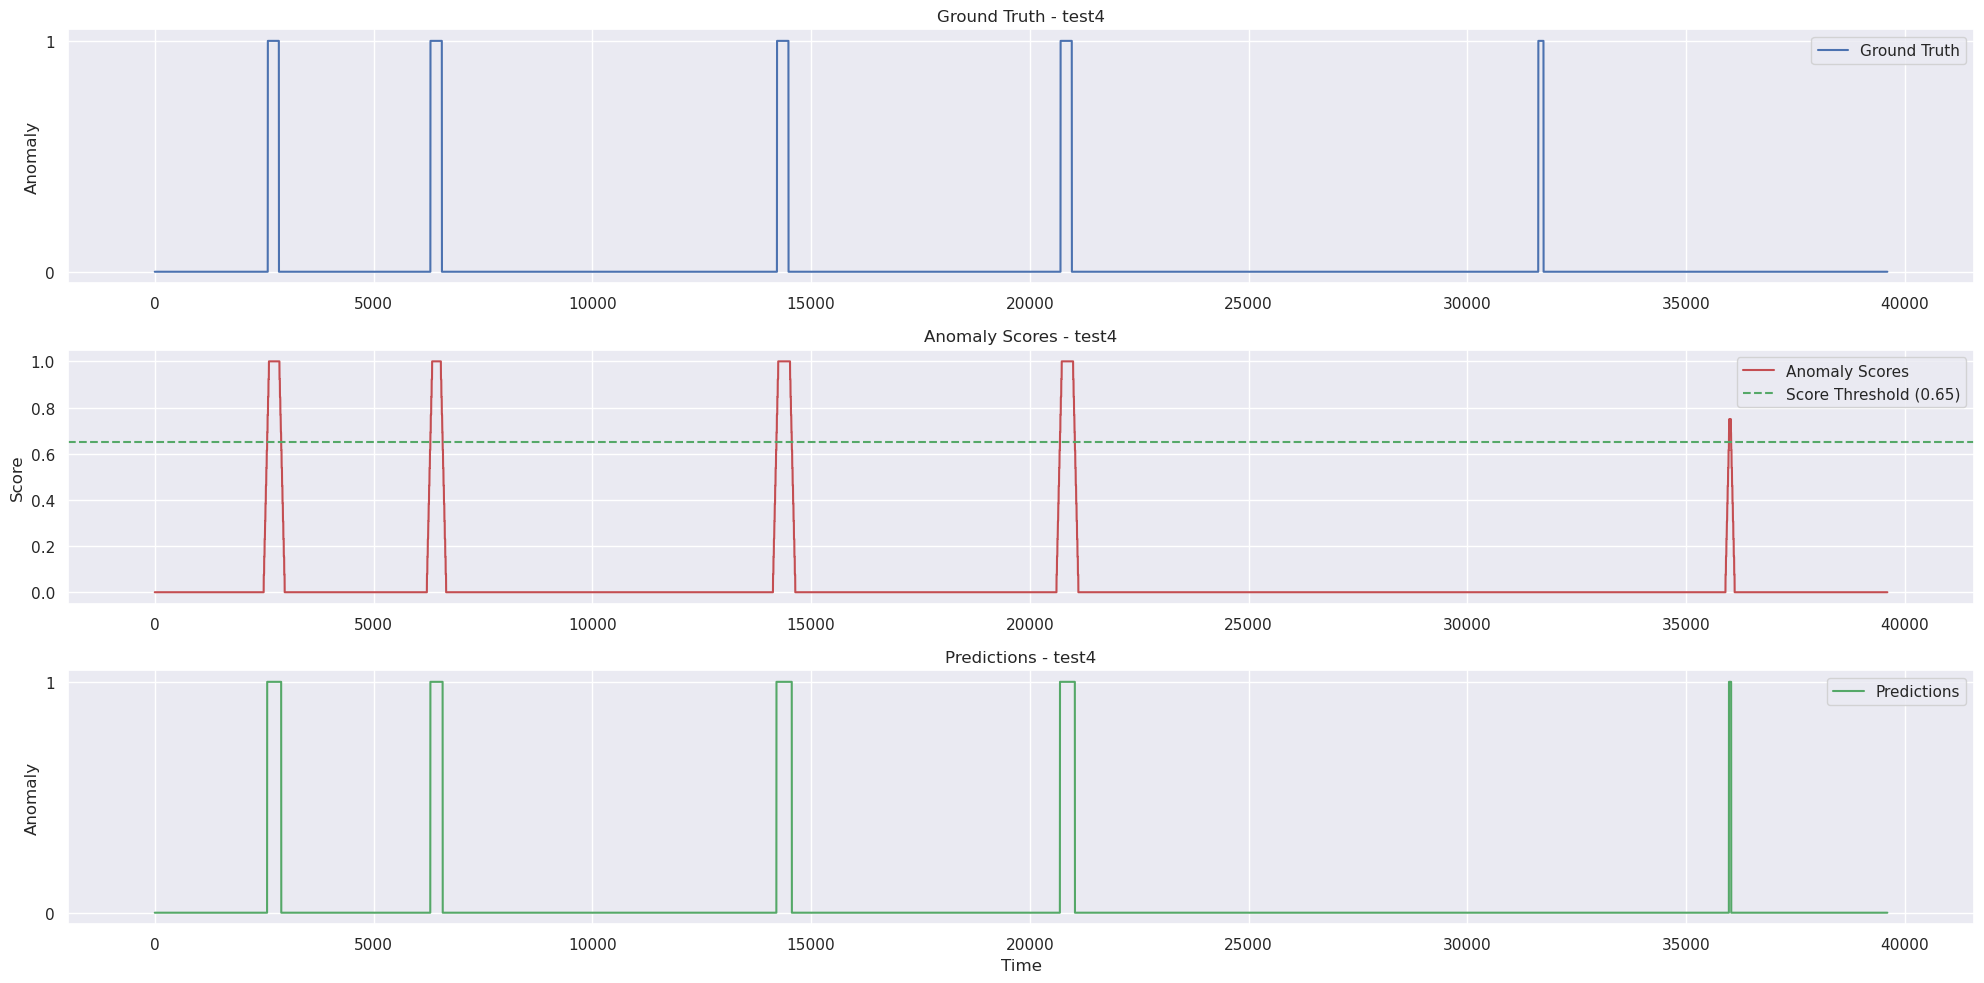

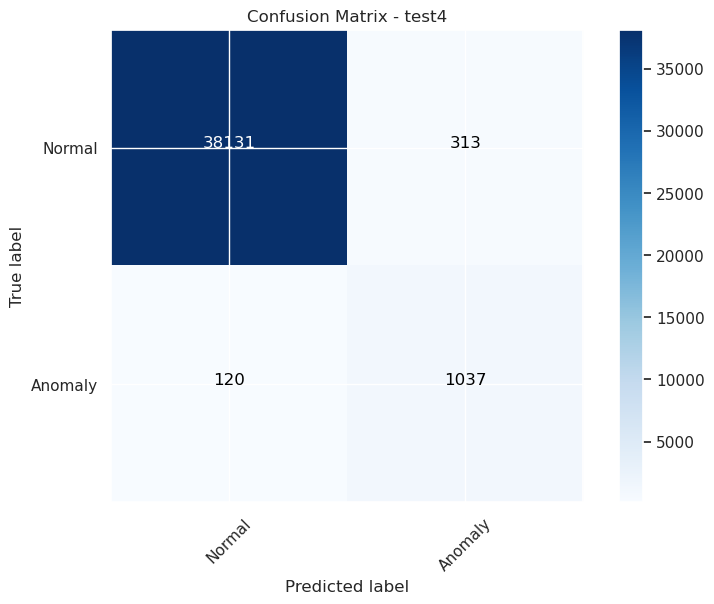

,Test File,Precision,Recall,F1 Score,Accuracy,False Positive Rate,False Negative Rate
0,test1,0.738701,0.831479,0.782349,0.993264,0.004346,0.168521
1,test2,0.614075,0.387069,0.474835,0.975143,0.007273,0.612931
2,test5,0.579044,0.723473,0.643251,0.981093,0.012691,0.276527
3,test3,0.586982,0.646254,0.615194,0.988509,0.006556,0.353746
4,test4,0.768148,0.896283,0.827284,0.989066,0.008142,0.103717


In [13]:
# Evaluate on all test files
results = []
for test_name, test_df in test_data.items():
    result = evaluate_test_file(test_name, test_df)
    results.append({
        'Test File': result['Test File'],
        'Precision': result['Precision'],
        'Recall': result['Recall'],
        'F1 Score': result['F1 Score'],
        'Accuracy': result['Accuracy'],
        'False Positive Rate': result['False Positive Rate'],
        'False Negative Rate': result['False Negative Rate']
    })

# Create DataFrame with results
results_df = pd.DataFrame(results)

# Display results
results_df

## 6. Visualize Results Across Test Files

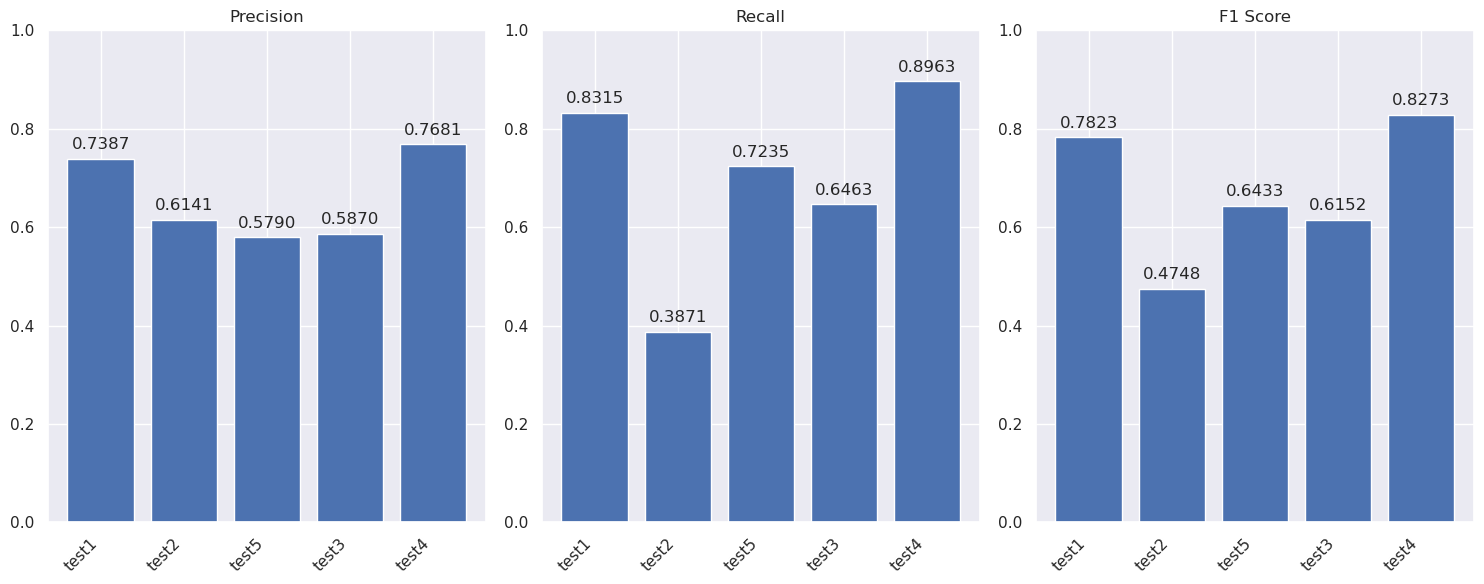

In [14]:
# Visualize metrics across test files
metrics = ['Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(15, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(results_df['Test File'], results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add value labels
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

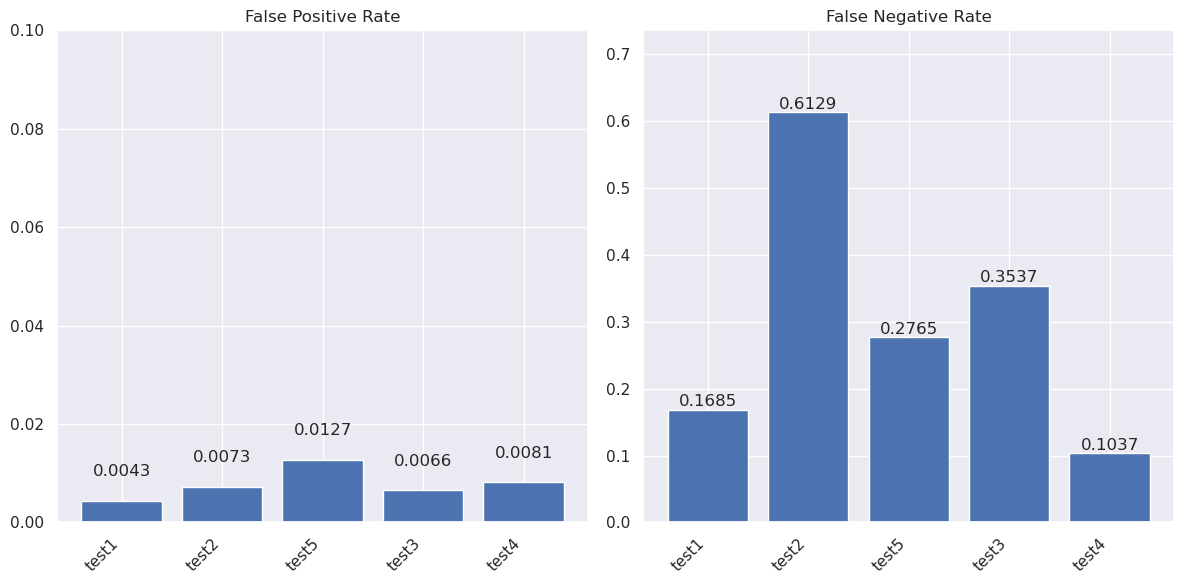

In [15]:
# Visualize error rates
error_metrics = ['False Positive Rate', 'False Negative Rate']
plt.figure(figsize=(12, 6))

for i, metric in enumerate(error_metrics):
    plt.subplot(1, 2, i+1)
    plt.bar(results_df['Test File'], results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(results_df[metric].max() * 1.2, 0.1))
    
    # Add value labels
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

In [16]:
# Calculate average metrics
avg_metrics = {
    'Precision': results_df['Precision'].mean(),
    'Recall': results_df['Recall'].mean(),
    'F1 Score': results_df['F1 Score'].mean(),
    'Accuracy': results_df['Accuracy'].mean(),
    'False Positive Rate': results_df['False Positive Rate'].mean(),
    'False Negative Rate': results_df['False Negative Rate'].mean()
}

# Display average metrics
print("Average Metrics Across All Test Files:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

Average Metrics Across All Test Files:
Precision: 0.6574
Recall: 0.6969
F1 Score: 0.6686
Accuracy: 0.9854
False Positive Rate: 0.0078
False Negative Rate: 0.3031


## 7. Sensitivity Analysis

In [17]:
# Perform sensitivity analysis on anomaly score threshold
def sensitivity_analysis(test_name, test_df, thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]):
    """
    Perform sensitivity analysis on anomaly score threshold.
    
    Args:
        test_name (str): Name of the test file
        test_df (pd.DataFrame): Test dataframe
        thresholds (list): List of thresholds to test
        
    Returns:
        pd.DataFrame: Results for each threshold
    """
    # Extract features
    X_test_features = test_df[top_features].values
    
    # Extract labels
    y_test = test_df['attack'].values if 'attack' in test_df.columns else None
    
    # Scale data
    X_test_scaled = scaler.transform(X_test_features)
    
    # Apply PCA
    X_test_pca = pca.transform(X_test_scaled)
    
    # Create sequences
    X_test_seq = create_sequences(X_test_pca, SEQ_LENGTH, STRIDE)
    
    # Get predictions from model
    X_test_pred = model.predict(X_test_seq)
    mse = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))
    
    # Initialize anomaly scores array
    anomaly_scores = np.zeros(len(y_test))
    count = np.zeros(len(y_test))
    
    # For each sequence, if it's anomalous, increment the score for all points in the sequence
    for i, error in enumerate(mse):
        idx = i * STRIDE
        if idx + SEQ_LENGTH <= len(y_test):
            if error > threshold:
                anomaly_scores[idx:idx+SEQ_LENGTH] += 1
            count[idx:idx+SEQ_LENGTH] += 1
    
    # Normalize scores by count
    anomaly_scores = np.divide(anomaly_scores, count, out=np.zeros_like(anomaly_scores), where=count!=0)
    
    # Test different thresholds
    results = []
    for t in thresholds:
        # Apply threshold to get binary labels
        anomaly_labels = (anomaly_scores > t).astype(int)
        
        # Apply post-processing
        anomaly_labels = post_process_anomalies(anomaly_labels, min_anomaly_length=MIN_ANOMALY_LENGTH, gap_threshold=GAP_THRESHOLD)
        
        # Calculate metrics
        precision = precision_score(y_test, anomaly_labels)
        recall = recall_score(y_test, anomaly_labels)
        f1 = f1_score(y_test, anomaly_labels)
        
        # Add to results
        results.append({
            'Threshold': t,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    return pd.DataFrame(results)

In [18]:
# Perform sensitivity analysis on first test file
test_name = list(test_data.keys())[0]
test_df = test_data[test_name]

sensitivity_results = sensitivity_analysis(test_name, test_df)
sensitivity_results

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 


,Threshold,Precision,Recall,F1 Score
0,0.50,0.607609,0.888712,0.721756
1,0.55,0.689086,0.863275,0.766408
2,0.60,0.698187,0.856916,0.769450
3,0.65,0.738701,0.831479,0.782349
4,0.70,0.789809,0.788553,0.789181
5,0.75,0.797386,0.775835,0.786463
6,0.80,0.832117,0.724960,0.774851


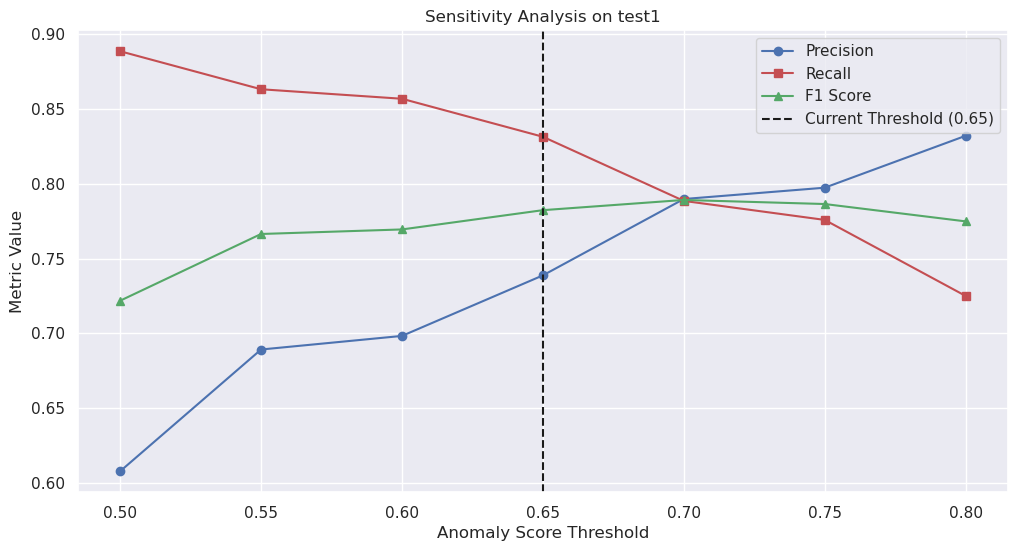

In [19]:
# Visualize sensitivity analysis results
plt.figure(figsize=(12, 6))
plt.plot(sensitivity_results['Threshold'], sensitivity_results['Precision'], 'b-', marker='o', label='Precision')
plt.plot(sensitivity_results['Threshold'], sensitivity_results['Recall'], 'r-', marker='s', label='Recall')
plt.plot(sensitivity_results['Threshold'], sensitivity_results['F1 Score'], 'g-', marker='^', label='F1 Score')
plt.axvline(x=ANOMALY_SCORE_THRESHOLD, color='k', linestyle='--', label=f'Current Threshold ({ANOMALY_SCORE_THRESHOLD})')
plt.title(f'Sensitivity Analysis on {test_name}')
plt.xlabel('Anomaly Score Threshold')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.show()

## 8. Save Results

In [20]:
# Save results to CSV
results_df.to_csv(os.path.join(MODEL_DIR, 'evaluation_results.csv'), index=False)
print(f"Saved evaluation results to {os.path.join(MODEL_DIR, 'evaluation_results.csv')}")

# Save sensitivity analysis results
sensitivity_results.to_csv(os.path.join(MODEL_DIR, 'sensitivity_analysis.csv'), index=False)
print(f"Saved sensitivity analysis results to {os.path.join(MODEL_DIR, 'sensitivity_analysis.csv')}")

Saved evaluation results to ../../models/simplified_lstm/evaluation_results.csv
Saved sensitivity analysis results to ../../models/simplified_lstm/sensitivity_analysis.csv
